# Import Libraries and Data

## Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from copy import deepcopy
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn import tree

## Evaluation

In [2]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def confusion_matrix_report(y_true, y_pred):    
    cm, labels = confusion_matrix(y_true, y_pred), unique_labels(y_true, y_pred)
    column_width = max([len(str(x)) for x in labels] + [5])  # 5 is value length
    report = " " * column_width + " " + "{:_^{}}".format("Prediction", column_width * len(labels))+ "\n"
    report += " " * column_width + " ".join(["{:>{}}".format(label, column_width) for label in labels]) + "\n"
    for i, label1 in enumerate(labels):
        report += "{:>{}}".format(label1, column_width) + " ".join(["{:{}d}".format(cm[i, j], column_width) for j in range(len(labels))]) + "\n"
    return report

import math

def calc_rmse(predicted, target):
    error = pd.DataFrame()
    error['Text'] = target + predicted
    conditions = [(error['Text'] == "1_low1_low"),
                 (error['Text'] == "2_middle2_middle"),
                 (error['Text'] == "3_high3_high"),
                 (error['Text'] == "1_low3_high"),
                 (error['Text'] == "3_high1_low")]
    choices = [0,0,0,2,2]
    error['numeric'] = np.select(conditions, choices, default = 1)
    rmse = math.sqrt((error['numeric']*error['numeric']).mean())
    print(rmse)
    return rmse

def evaluation(prediction, label):
    print(classification_report(label, prediction))
    print(confusion_matrix_report(label, prediction))
    print("Root Mean squared Error: {}".format(calc_rmse(prediction, label)))

## Data

In [3]:
red = pd.read_csv("./data/winequality-red1.csv")
white = pd.read_csv("./data/winequality-white1.csv")

# Data Manipulation and Preprocessing

In [4]:
conditions_white = [(white['quality'] <= 5),
              (white['quality'] >= 7)]
choices = ['1_low', '3_high']
white['quality_class'] = np.select(conditions_white, choices, default = '2_middle')
conditions_red = [(red['quality'] <= 5),
              (red['quality'] >= 7)]
red['quality_class'] = np.select(conditions_red, choices, default = '2_middle')

In [5]:
white_data = white.drop(['quality', 'quality_class'], axis = 1)
red_data = red.drop(['quality', 'quality_class'], axis = 1)

In [6]:
white_label = white['quality_class']
red_label = red['quality_class']

# Classification - Red Wine

## Comparison of Naive Bayes classifiers

In [7]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

classifiers = [
    GaussianNB(),
    MultinomialNB(),
    BernoulliNB()]

for clf in classifiers:
    prediction = cross_val_predict(clf, red_data, red_label, cv=cv)
    name = clf.__class__.__name__
    
    print("-"*50)
    print(name)
    
    evaluation(prediction, red_label)

--------------------------------------------------
GaussianNB
             precision    recall  f1-score   support

      1_low       0.71      0.71      0.71       744
   2_middle       0.54      0.50      0.52       638
     3_high       0.45      0.56      0.50       217

avg / total       0.61      0.61      0.61      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     529      187       28
2_middle     198      317      123
  3_high      16       79      122

0.6907772674826483
Root Mean squared Error: 0.6907772674826483
--------------------------------------------------
MultinomialNB
             precision    recall  f1-score   support

      1_low       0.63      0.49      0.55       744
   2_middle       0.48      0.41      0.44       638
     3_high       0.24      0.53      0.33       217

avg / total       0.52      0.46      0.48      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     361      213     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Gaussian Naive Bayes shows the best results (RMSE=0.69)

In [8]:
### Creating basic model to compare ###
model_bayes = GaussianNB()
prediction_red = cross_val_predict(model_bayes, red_data, red_label, cv=cv)

## Comparison of classifiers with discretised data

In [9]:
### Discretize data ###
red_binned = deepcopy(red_data)
attributes = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

for i in attributes:
    red_binned["{}".format(i)] = pd.qcut(red_binned["{}".format(i)], 4, labels=[0, 1, 2, 3])


In [10]:
for clf in classifiers:
    prediction = cross_val_predict(clf, red_binned, red_label, cv=cv)
    name = clf.__class__.__name__
    
    print("-"*50)
    print(name)
    evaluation(prediction, red_label)

--------------------------------------------------
GaussianNB
             precision    recall  f1-score   support

      1_low       0.69      0.75      0.72       744
   2_middle       0.54      0.43      0.48       638
     3_high       0.45      0.59      0.51       217

avg / total       0.60      0.60      0.59      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     558      154       32
2_middle     239      273      126
  3_high      12       76      129

0.6943891993868717
Root Mean squared Error: 0.6943891993868717
--------------------------------------------------
MultinomialNB
             precision    recall  f1-score   support

      1_low       0.70      0.76      0.73       744
   2_middle       0.55      0.49      0.52       638
     3_high       0.48      0.48      0.48       217

avg / total       0.61      0.61      0.61      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     564      158     

With discrete data, Multinomial Naive Bayes performs best (RMSE=0.67)

In [11]:
### Create basic model to compare ###
model_multi = MultinomialNB()
prediction_red_multi = cross_val_predict(model_bayes, red_binned, red_label, cv=cv)


## Improving Power of Gaussian NB

### Feature selection

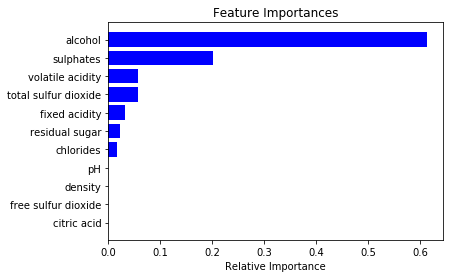

In [43]:
### Use a Decision Tree with the best results after GridSearch to find the most important features ###
decision_tree_red = tree.DecisionTreeClassifier(class_weight=None, max_depth=5, criterion='entropy', min_samples_split=150)
decision_tree_red.fit(red_data, red_label)

features = red_data.columns
importances = decision_tree_red.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.savefig('../wineForTheWin/importances_white.png')


Alcohol, sulphates, volatile acidity, total sulphur dioxide, fixed acidity, residual sugar and chlorides are important features.

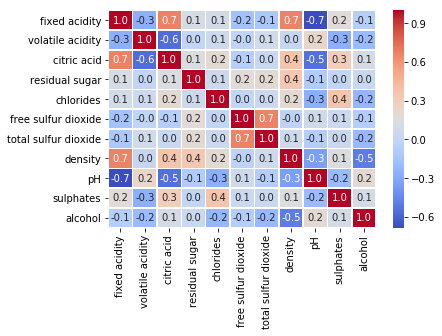

In [44]:
### Find correlations in data

sns.heatmap(red_data.corr(),cmap='coolwarm',annot=True, linewidths=.5, fmt= '.1f')

After looking at correlations and importances, alcohol, sulphates, volatile acidity and total sulfur dioxide are kept as important not that highly correlated features.

Free sulfur dioxide is highly correlated with total sulfur dioxide and chlorides is highly correlated with sulphates.

In [48]:
### Drop irrelevant and highly correlated features and make prediction ###
red_data_selected = deepcopy(red_data)
red_data_selected.pop("pH") # low importances, thus removed
red_data_selected.pop("density") # low importances, thus removed
red_data_selected.pop("free sulfur dioxide") # # low importances, thus removed
red_data_selected.pop("citric acid") # low importances, thus removed
red_data_selected.pop("chlorides") # correlated with sulphates, thus removed
red_data_selected.pop("fixed acidity") # correlated with sulphates, thus removed
red_data_selected.pop("residual sugar") # correlated with sulphates, thus removed
print("Unimportant features are removed")

prediction_red_selected = cross_val_predict(model_bayes, red_data_selected, red_label, cv=cv)

Unimportant features are removed


In [50]:
### PCA to fit the independence assumption ###
pca = PCA(n_components = 'mle', svd_solver = 'full')

## All attributes ##
red_data_pca = pd.DataFrame(pca.fit_transform(red_data))
prediction_red_pca = cross_val_predict(model_bayes, red_data_pca, red_label, cv=cv)

## Selected attributes ##
red_data_pca_selected = pd.DataFrame(pca.fit_transform(red_data_selected))
prediction_red_pca_selected = cross_val_predict(model_bayes, red_data_pca_selected, red_label, cv=cv)


### Data Transformations

In [51]:
### Transform data to get a normal distribution via logarithm ###

## All attributes ##
red_data_log = np.log(red_data + 1)
prediction_red_log = cross_val_predict(model_bayes, red_data_log, red_label, cv=cv)

## selected attributes ##
red_data_selected_log = np.log(red_data_selected)
prediction_red_selected_log = cross_val_predict(model_bayes, red_data_selected_log, red_label, cv=cv)

In [52]:
### Transform selected data to get a normal distribution via MinMax Scaler ###

## All attributes ##
red_minmax=(red_data-red_data.min())/(red_data.max()-red_data.min())
prediction_red_minmax = cross_val_predict(model_bayes, red_minmax, red_label, cv=cv)

## Selected attributes ##
red_selected_minmax=(red_data_selected-red_data_selected.min())/(red_data_selected.max()-red_data_selected.min())
prediction_red_selected_minmax = cross_val_predict(model_bayes, red_selected_minmax, red_label, cv=cv)

### Comparison of models

In [53]:
prediction_transformed = [prediction_red,
             prediction_red_selected,
             prediction_red_pca,
             prediction_red_log,             
             prediction_red_minmax,
             prediction_red_selected_log,
             prediction_red_selected_minmax,
             prediction_red_pca_selected]

method = ["GNB (normal)", 
          "GNB selected", 
          "GNB PCA",
          "GNB logarithm",
          "GNB minmax",
          "GNB selected logarithm",
          "GNB selected minmax",
          "PCA selected"]

for i, j in zip(prediction_transformed, method):
    print("-"*50)
    print(j)
    evaluation(i, red_label)

--------------------------------------------------
GNB (normal)
             precision    recall  f1-score   support

      1_low       0.71      0.71      0.71       744
   2_middle       0.54      0.50      0.52       638
     3_high       0.45      0.56      0.50       217

avg / total       0.61      0.61      0.61      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     529      187       28
2_middle     198      317      123
  3_high      16       79      122

0.6907772674826483
Root Mean squared Error: 0.6907772674826483
--------------------------------------------------
GNB selected
             precision    recall  f1-score   support

      1_low       0.72      0.76      0.74       744
   2_middle       0.56      0.59      0.57       638
     3_high       0.56      0.35      0.43       217

avg / total       0.63      0.64      0.63      1599

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     568      170    

Transforming the data into normal form does not improve the performance. With the selected features, the RMSE decreases by 0.06 with PCA by 0.05.

## Classification - White wine

In [59]:
for clf in classifiers:
    prediction_white = cross_val_predict(clf, white_data, white_label, cv=cv)
    name = clf.__class__.__name__
    
    print("-"*50)
    print(name)
    
    evaluation(prediction_white, white_label)

--------------------------------------------------
GaussianNB
             precision    recall  f1-score   support

      1_low       0.57      0.56      0.56      1640
   2_middle       0.52      0.35      0.42      2198
     3_high       0.41      0.70      0.52      1060

avg / total       0.51      0.50      0.49      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     914      515      211
2_middle     579      770      849
  3_high     113      201      746

0.8380498079495802
Root Mean squared Error: 0.8380498079495802
--------------------------------------------------
MultinomialNB
             precision    recall  f1-score   support

      1_low       0.49      0.46      0.48      1640
   2_middle       0.48      0.49      0.49      2198
     3_high       0.36      0.38      0.37      1060

avg / total       0.46      0.46      0.46      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     762      666     

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Gaussian Naive Bayes shows the best results (RMSE=0.83)

In [60]:
### Creating basic model to compare ###
prediction_white = cross_val_predict(model_bayes, white_data, white_label, cv=cv)

## Comparison of classifiers with discretised data

In [61]:
### Discretize data ###
white_binned = deepcopy(white_data)
attributes = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

for i in attributes:
    white_binned["{}".format(i)] = pd.qcut(white_binned["{}".format(i)], 4, labels=[0, 1, 2, 3])


In [62]:
for clf in classifiers:
    prediction = cross_val_predict(clf, white_binned, white_label, cv=cv)
    name = clf.__class__.__name__
    
    print("-"*50)
    print(name)
    evaluation(prediction, white_label)

--------------------------------------------------
GaussianNB
             precision    recall  f1-score   support

      1_low       0.54      0.66      0.60      1640
   2_middle       0.53      0.35      0.42      2198
     3_high       0.44      0.61      0.51      1060

avg / total       0.51      0.51      0.50      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low    1077      396      167
2_middle     769      759      670
  3_high     134      281      645

0.8233029119159567
Root Mean squared Error: 0.8233029119159567
--------------------------------------------------
MultinomialNB
             precision    recall  f1-score   support

      1_low       0.57      0.62      0.59      1640
   2_middle       0.53      0.46      0.49      2198
     3_high       0.46      0.53      0.49      1060

avg / total       0.53      0.53      0.53      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low    1010      509     

With discrete data, Bernoulli Naive Bayes works best (RMSE=0.79)

In [64]:
### Create basic model to compare ###
prediction_white_multi = cross_val_predict(BernoulliNB(), white_binned, white_label, cv=cv)


## Improving Power of Gaussian NB

### Feature selection

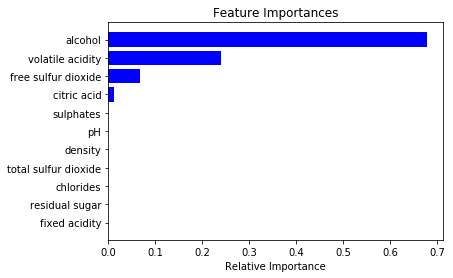

In [65]:
### Use a Decision Tree with the best results after GridSearch to find the most important features ###

decision_tree_white = tree.DecisionTreeClassifier(class_weight=None, max_depth=3, criterion="entropy", min_samples_split=50)
decision_tree_white.fit(white_data, white_label)


features = white_data.columns
importances = decision_tree_white.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.savefig('../wineForTheWin/importances_white.png')


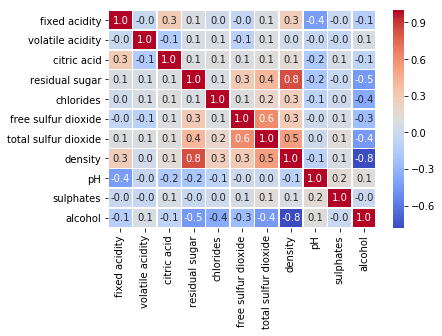

In [72]:
### Find correlations in data ###

sns.heatmap(white_data.corr(),cmap='coolwarm',annot=True, linewidths=.5, fmt= '.1f')

In [ ]:
## Drop irrelevant nd unimportant features and make classification##
white_data_selected = deepcopy(white_data)
white_data_selected.pop("residual sugar") # low importances, thus removed
white_data_selected.pop("sulphates") # # low importances, thus removed
white_data_selected.pop("total sulfur dioxide") # low importances, thus removed
white_data_selected.pop("pH") # low importances, thus removed
white_data_selected.pop("density") # Highly correlated with alcohol, thus removed
white_data_selected.pop("chlorides") # Highly correlated with alcohol, thus removed
white_data_selected.pop("fixed acidity") # Highly correlated with pH and low importance, thus removed
white_data_selected.pop("citric acid") # Highly correlated with fixed acidity, thus removed


prediction_white_selected = cross_val_predict(model_bayes, white_data_selected, white_label, cv=cv)
print("Unimportant features are removed")

Alcohol, volatile acidity and free sulfur dioxide are kept as important features.

In [73]:
### PCA to fit the independence assumption ###
pca = PCA(n_components = 'mle', svd_solver = 'full')

## All attributes ##
white_data_pca = pd.DataFrame(pca.fit_transform(white_data))
prediction_white_pca = cross_val_predict(model_bayes, white_data_pca, white_label, cv=cv)

## Selected attributes ##
white_data_pca_selected = pd.DataFrame(pca.fit_transform(white_data_selected))
prediction_white_pca_selected = cross_val_predict(model_bayes, white_data_pca_selected, white_label, cv=cv)


### Data transformations

In [74]:
### Transform data to get a normal distribution via logarithm ###

## All attributes ##
white_data_log = np.log(white_data + 1)
prediction_white_log = cross_val_predict(model_bayes, white_data_log, white_label, cv=cv)

## selected attributes ##
white_data_selected_log = np.log(white_data_selected)
prediction_white_selected_log = cross_val_predict(model_bayes, white_data_selected_log, white_label, cv=cv)

In [75]:
### Transform selected data to get a normal distribution via MinMax Scaler ###

## All attributes ##
white_minmax=(white_data-white_data.min())/(white_data.max()-white_data.min())
prediction_white_minmax = cross_val_predict(model_bayes, white_minmax, white_label, cv=cv)

## Selected attributes ##
white_selected_minmax=(white_data_selected-white_data_selected.min())/(white_data_selected.max()-white_data_selected.min())
prediction_white_selected_minmax = cross_val_predict(model_bayes, white_selected_minmax, white_label, cv=cv)

### Comparison of models

In [76]:
prediction_transformed = [prediction_white,
             prediction_white_selected,
             prediction_white_pca,
             prediction_white_log,             
             prediction_white_minmax,
             prediction_white_selected_log,
             prediction_white_selected_minmax,
             prediction_white_pca_selected]

method = ["GNB (normal)", 
          "GNB selected", 
          "GNB PCA",
          "GNB logarithm",
          "GNB minmax",
          "GNB selected logarithm",
          "GNB selected minmax",
          "PCA selected"]

for i, j in zip(prediction_transformed, method):
    print("-"*50)
    print(j)
    evaluation(i, white_label)

--------------------------------------------------
GNB (normal)
             precision    recall  f1-score   support

      1_low       0.57      0.56      0.56      1640
   2_middle       0.52      0.35      0.42      2198
     3_high       0.41      0.70      0.52      1060

avg / total       0.51      0.50      0.49      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     914      515      211
2_middle     579      770      849
  3_high     113      201      746

0.8380498079495802
Root Mean squared Error: 0.8380498079495802
--------------------------------------------------
GNB selected
             precision    recall  f1-score   support

      1_low       0.64      0.50      0.56      1640
   2_middle       0.50      0.67      0.58      2198
     3_high       0.54      0.34      0.42      1060

avg / total       0.56      0.54      0.54      4898

         _______Prediction_______
           1_low 2_middle   3_high
   1_low     825      790    

After transforming the data to normal form via logarithm and seleting features we can see an increase of 0.07 for F1 and a decrease in R2 of 0.15